<a href="https://colab.research.google.com/github/cassyay/open-source-projects/blob/master/food-101/food_101_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of Contents


*   Motivation and Problem Statement
*   Examining Data Content
*   Examining Image Content
*   Data Augmentation
*   Validation Set
*   ResNet50
*   Training and Validation
*   Testing the Model
*   Top-k Results
*   Summary and Takeaway



## Motivation and Problem Statement

Over the last few years, deep learning has taken large strides in complexity and technique.   Just x years ago, the MNIST dataset made breakthroughs in computer vision.  There are now several specializations of deep learning that offer different approaches to AI -- GANS, NLP, reinforcement learning, etc.  The technology behind MNIST these days pales in comparison to the potential of DL.
As AI becomes more integrated in our daily lives, more interested people are gravitating towards deep learning and machine learning fields.  There are several resources, from traditional university courses to MOOCs to textbooks, open-source projects, blogs, and videos.  These courses offer foundational training as well as specialized training in areas of deep learning.   

The MNIST and CIFAR-10 datasets offer a good very first introduction to building a CNN to classify images.  But, they are not good as an introduction to many steps of deep learning that are an integral part of every machine learner’s understanding--data preparation, augmentation, feature engineering, pre-trained models, etc.  Additionally, they are not so relevant to people’s lives, or offer a good example of cutting-edge AI.  A dataset that requires data preparation, feature engineering, model selection, training, and testing, as well as show the potentiality of deep learning, should be introduced in foundational teaching.
The Food-101 dataset offers the opportunity to work with a real-world dataset -- messy data, diverse imagery, etc. The dataset is organized similarly to how data is often encountered in real world scenarios.  Additionally, the type of classification used in Food 101 is a challenge being approached by many.  

In [0]:
#import libraries

import os
import sys
from shutil import copy
from PIL import Image
import random
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
%matplotlib inline

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data.sampler import SubsetRandomSampler
from collections import OrderedDict

In [0]:
#check python and library versions

print('Python version: ', sys.version)
print('Matplotlib version: ', matplotlib.__version__)
print('NumPy version: ', np.__version__)
print('Pytorch version: ', torch.__version__)
print('Torchvision version: ', torchvision.__version__)
print('Pandas version: ', pd.__version__)

Python version:  3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
Matplotlib version:  3.1.3
NumPy version:  1.17.5
Pytorch version:  1.4.0
Torchvision version:  0.5.0
Pandas version:  0.25.3


## Examining Data Content

The dataset contains several folders:


*   **food-101/**: folder containing all subsequent files 
*   **food-101/images/**: folder containing all images, separated by category into folders
*   **food-101/meta/**: contains `classes.txt`, `labels.txt`, `train.txt`, and `test.txt`, which contain labels for each category, as well as the key to map images to train and test folders.

The following code downloads and examines the content of the dataset.




In [0]:
#download data

!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
!tar xzvf food-101.tar.gz

In [0]:
#assign names to each path

data_dir = 'food-101'
image_dir = data_dir + '/images'
meta_dir = data_dir + '/meta'
classes_dir = meta_dir + '/classes.txt'
labels_dir = meta_dir + '/labels.txt'
train_dir = meta_dir + '/train.txt'
test_dir = meta_dir + '/test.txt'

In [0]:
#print label names

#labels = open(labels_dir)
#for label in labels.read().split():
#  print(label)

In [0]:
#examine contents of each folder 

print('Image files: ')
!head 'food-101/meta/train.txt'
print('\nLabels: ')
!head 'food-101/meta/labels.txt'
print('\nClasses: ')
!head 'food-101/meta/classes.txt'

Image files: 
apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856

Labels: 
Apple pie
Baby back ribs
Baklava
Beef carpaccio
Beef tartare
Beet salad
Beignets
Bibimbap
Bread pudding
Breakfast burrito

Classes: 
apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


In [0]:
#split images in to a train folder and test folder, using .txt files as key

def split_data(path, src, dst):

  #extract image names
  image_class = defaultdict(list)
  with open(path, 'r') as txt:
    paths = [read.strip() for read in txt.readlines()]
    for n in paths:
      food = n.split('/')
      image_class[food[0]].append(food[1] + '.jpg')

  #create folders and paths for images
  for food in image_class.keys():
    if not os.path.exists(os.path.join(dst, food)):
      os.makedirs(os.path.join(dst, food))
    for i in image_class[food]:
      copy(os.path.join(src, food, i), os.path.join(dst, food, i))

split_data(train_dir, image_dir, data_dir + '/train')
split_data(test_dir, image_dir, data_dir + '/test')

In [0]:
train_folder = data_dir + '/train'
test_folder = data_dir + '/test'

Using a dataframe will give an idea of how many images are in each class between training and test folders.

In [0]:
#examine content of .txt files

train_df = pd.read_csv(train_dir)
print(train_df)
print(train_df.count())
test_df = pd.read_csv(test_dir)
print(test_df)
print(test_df.count())

       apple_pie/1005649
0      apple_pie/1014775
1      apple_pie/1026328
2      apple_pie/1028787
3      apple_pie/1043283
4      apple_pie/1050519
...                  ...
75744     waffles/981485
75745      waffles/98238
75746     waffles/982668
75747     waffles/995085
75748     waffles/999047

[75749 rows x 1 columns]
apple_pie/1005649    75749
dtype: int64
       apple_pie/1011328
0       apple_pie/101251
1      apple_pie/1034399
2       apple_pie/103801
3      apple_pie/1038694
4      apple_pie/1047447
...                  ...
25244     waffles/942009
25245     waffles/954028
25246      waffles/96181
25247      waffles/97015
25248     waffles/971843

[25249 rows x 1 columns]
apple_pie/1011328    25249
dtype: int64


In [0]:
#examine contents of train and test folders

class_labels = []
labels = []
n_train = []
n_test = []

#iterate through train folder 
for d in os.listdir(train_folder):
    class_labels.append(d)
    #print(d)

    train_imgs = os.listdir(train_folder + '/' + d)
    test_imgs = os.listdir(test_folder + '/' + d)
    
    #number of images in train and test folders
    n_train.append(len(train_imgs))
    n_test.append(len(test_imgs))

#create dataframe
cat_df = pd.DataFrame({'class_label': class_labels,
                       'n_train': n_train,
                       'n_test': n_test}).\
    sort_values('class_label')


total = cat_df.sum(axis = 0, skipna = True)
print(total)
print('shape: ', cat_df.shape)
cat_df


class_label    apple_piebaby_back_ribsbaklavabeef_carpacciobe...
n_train                                                    75750
n_test                                                     25250
dtype: object
shape:  (101, 3)


class_label  n_train  n_test
14       apple_pie      750     250
46  baby_back_ribs      750     250
73         baklava      750     250
41  beef_carpaccio      750     250
34    beef_tartare      750     250
..             ...      ...     ...
4            tacos      750     250
23        takoyaki      750     250
47        tiramisu      750     250
0     tuna_tartare      750     250
70         waffles      750     250

[101 rows x 3 columns]

Using `cat_df.describe()` displays descriptive data, and shows that there are the same number of categories for both the train and test set, and that the data is evenly divided to 750 images per category for the train set, and 250 images per category for the test set, giving a 70/30 train/test split.

In [0]:
cat_df.describe()

n_train  n_test
count    101.0   101.0
mean     750.0   250.0
std        0.0     0.0
min      750.0   250.0
25%      750.0   250.0
50%      750.0   250.0
75%      750.0   250.0
max      750.0   250.0

In [0]:
#cat_df.set_index('category')['n_train'].plot.bar(
#    color='b', figsize=(35, 10))
#plt.ylabel('Count')
#plt.xticks(rotation=75)
#plt.title('Training images by class')
#plt.show()

#cat_df.set_index('category')['n_test'].plot.bar(
#    color='r', figsize=(35, 10))
#plt.ylabel('Count')
#plt.xticks(rotation=75)
#plt.title('Test images by class')
#plt.show()

## Examining Image Content

Examing what the images look like will help determine how they should be augmented.  Below is 50 randomly selected images from the training set, which will provide an overall glimpse of the dataset.
 <br>
The images have quite a bit of background noise, and color noise.  Within each class, the images do not always have the same shape, have different lighting, and may be with or without additional food items.

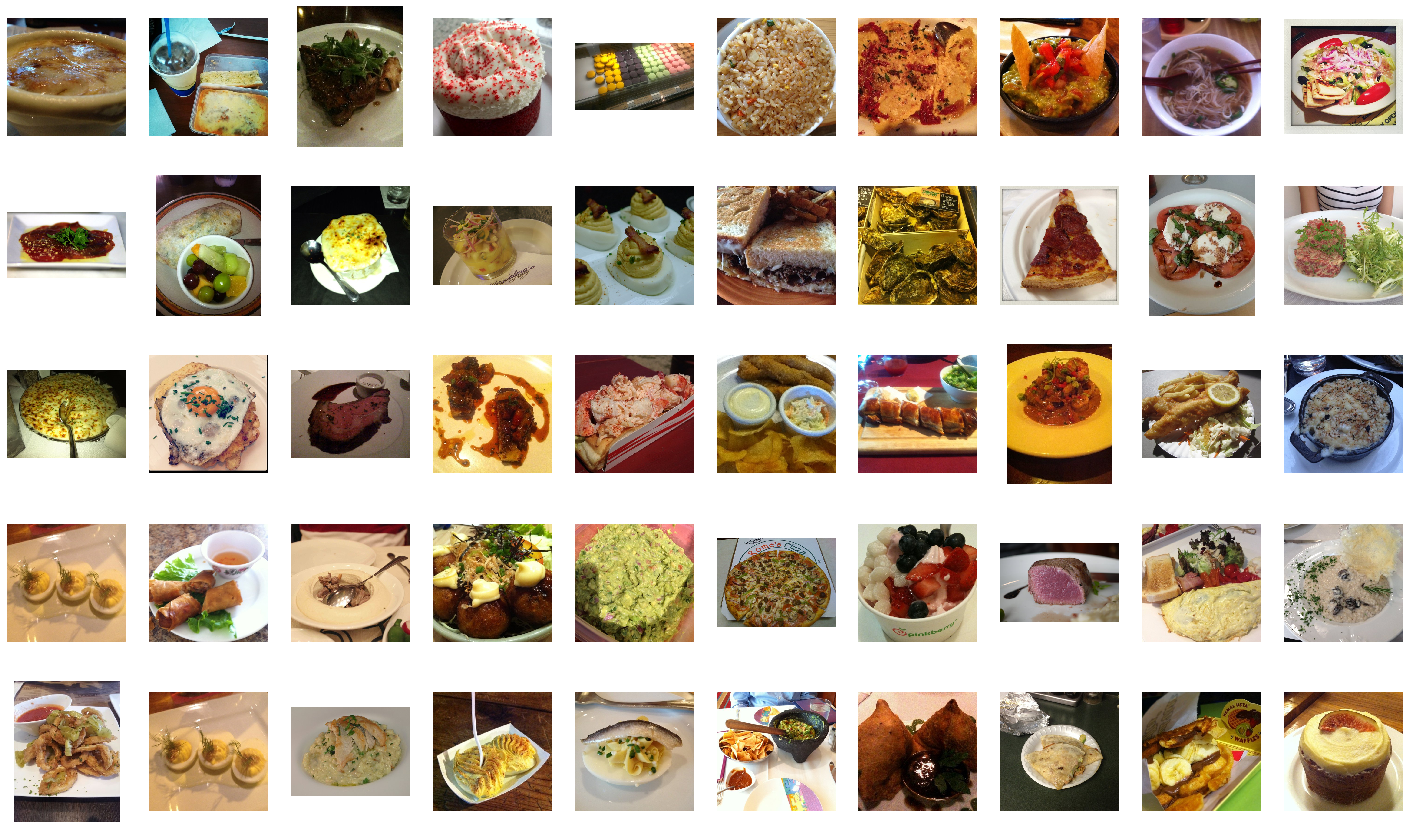

In [0]:
#display random images from training folder 

images = []
for folder in os.listdir(train_folder):
  for image in os.listdir(train_folder + '/' + folder):
    images.append(os.path.join(train_folder, folder, image))

plt.figure(1, figsize=(25, 15))
plt.axis('off')
n = 0
for i in range(50):
  n += 1
  random_img = random.choice(images)
  imgs = imread(random_img)
  plt.subplot(5, 10, n)
  axis('off')
  plt.imshow(imgs)

plt.show()

Examining some classes more closely show the variance within each class, and some similarities between classes:


*   Apple pie images show the difference in shape, lighting, and background noise can vary. 
*   Chocolate cake images also show a large range of shape and background noise.
*   The images of sushi vs. sashimi can be hard to differentiate, so smaller details such as the presence of rice with sushi may be important.
*   Poutine vs. french fries, both contain french fries, but poutine will have gravy and cheese.



In [0]:
#display images from a selected set of files 

def image_display(file_name, title):
    fig = figure(figsize=(25, 4))
    number_of_files = len(file_name)
    plt.title(title)
    plt.axis('off')
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = imread(file_name[i])

        imshow(image,cmap='Greys_r')
        axis('off')


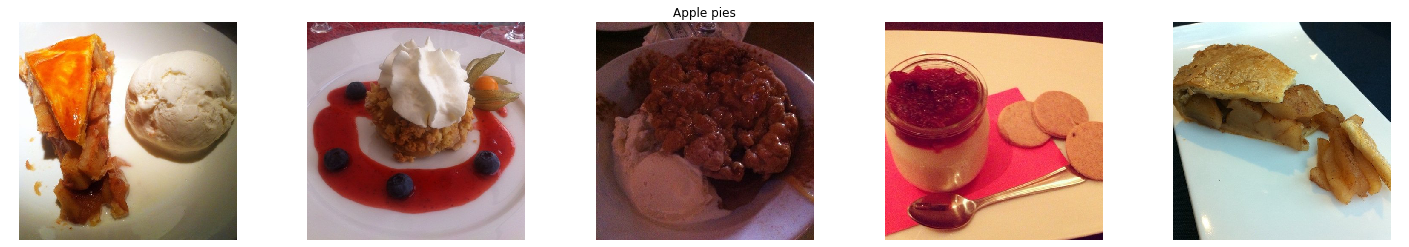

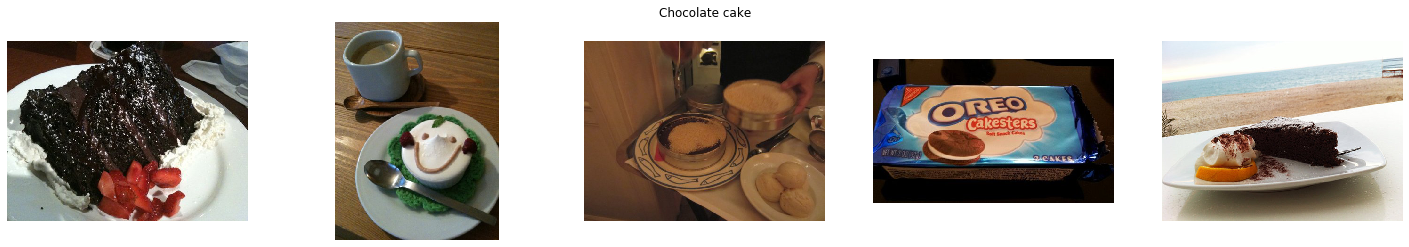

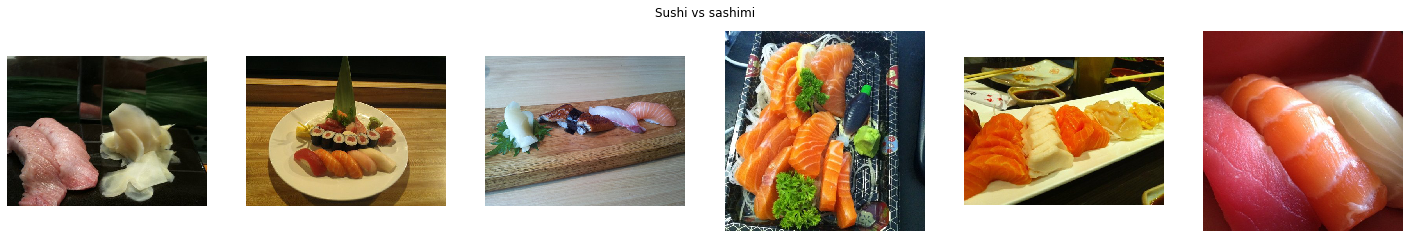

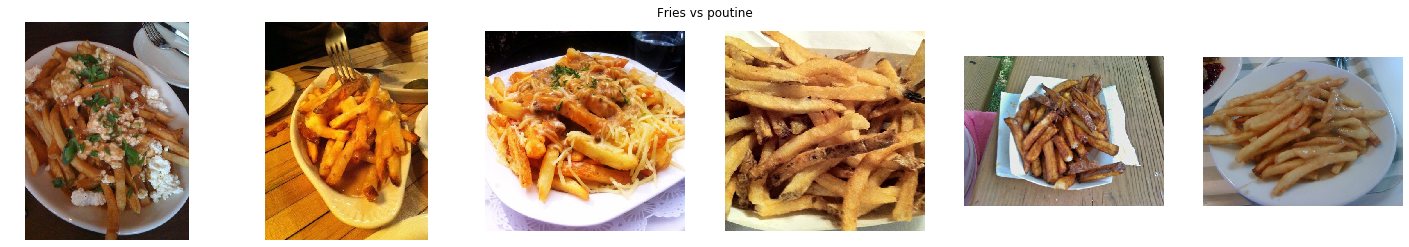

In [0]:
#apple pie
pie_dir = image_dir + '/apple_pie'

pie_files = [pie_dir + '/1057749.jpg',
                 pie_dir + '/2086645.jpg',
                 pie_dir + '/2109273.jpg',
                 pie_dir + '/2745186.jpg',
                 pie_dir + '/671980.jpg']

image_display(pie_files, title='Apple pies')

#chocolate cake
cake_dir = image_dir + '/chocolate_cake'

chocolate_cake = [cake_dir + '/126779.jpg',
                cake_dir + '/1246946.jpg',
                cake_dir + '/1305628.jpg', 
                cake_dir + '/1314985.jpg',
                cake_dir + '/1191566.jpg']

image_display(chocolate_cake, title='Chocolate cake')

#sushi vs. sashimi
sushi_dir = image_dir + '/sushi'
sashimi_dir = image_dir + '/sashimi'

sushi_sashimi = [sushi_dir + '/1325307.jpg',
                 sushi_dir + '/1456211.jpg',
                 sushi_dir + '/1991269.jpg',
                 sashimi_dir + '/1047291.jpg',
                 sashimi_dir + '/136070.jpg',
                 sashimi_dir + '/2284277.jpg']
  
image_display(sushi_sashimi, title='Sushi vs sashimi')

#french fries vs. poutine
poutine_dir = image_dir + '/poutine'
fries_dir = image_dir + '/french_fries'

fries_poutine = [poutine_dir + '/123677.jpg',
                 poutine_dir + '/150821.jpg',
                 poutine_dir + '/1930095.jpg',
                 fries_dir + '/459162.jpg',
                 fries_dir + '/2169665.jpg',
                 fries_dir + '/93653.jpg']
  
image_display(fries_poutine, title='Fries vs poutine')

## Data Augmentation 

Shape of food in each image varies, as was seen from the apple pie and chocolate cake classes.  Some different types of food have similar shapes and overall colors, but their difference lies in some texture and color differences.  For example, poutine will have cheese or gravy present in addition to french fries, and sushi may have rice or nori present. Lastly, there is a lot of background noise in many images that could be filtered out. <br><br>
Different foods may be most easily identifiable by their color and texture details. <br>
Some ways to augment the data are: 
- Rotating and flipping images -- since they are asymmetrical and their orientation does not need to be in the same place.  
- Augmenting brightness and saturation in the images. Hue and contrast is not augmented, because food color may play an important role in classification.  I am aiming to reduce lighting issues as well as intensify (but not alter) colors in the images.
- Images are resized to 224, the standard size for ResNet50.
- Cropping images will help remove some of the background noise that is present in many images.  The model should not learn to associate extraneous factors with the food itself.


## Validation Set

A training set and test set are already provided, but a validation set is useful in identifying overfitting.  If error on the validation set starts to increase, it is an indication that further training the model could lead to overfitting and it will generalize poorly with a new set of images.  For this dataset, I shuffled the training set and set aside 20% of the images for the validation set. 


In [0]:
#mapping class name to images

classes = os.listdir(train_folder)
classes.sort()
#print(classes)
label_mapping = {k: v for v, k in enumerate(classes)}

class_to_idx = {classes[i]: i for i in range(len(classes))}
print(class_to_idx)

{'apple_pie': 0, 'baby_back_ribs': 1, 'baklava': 2, 'beef_carpaccio': 3, 'beef_tartare': 4, 'beet_salad': 5, 'beignets': 6, 'bibimbap': 7, 'bread_pudding': 8, 'breakfast_burrito': 9, 'bruschetta': 10, 'caesar_salad': 11, 'cannoli': 12, 'caprese_salad': 13, 'carrot_cake': 14, 'ceviche': 15, 'cheese_plate': 16, 'cheesecake': 17, 'chicken_curry': 18, 'chicken_quesadilla': 19, 'chicken_wings': 20, 'chocolate_cake': 21, 'chocolate_mousse': 22, 'churros': 23, 'clam_chowder': 24, 'club_sandwich': 25, 'crab_cakes': 26, 'creme_brulee': 27, 'croque_madame': 28, 'cup_cakes': 29, 'deviled_eggs': 30, 'donuts': 31, 'dumplings': 32, 'edamame': 33, 'eggs_benedict': 34, 'escargots': 35, 'falafel': 36, 'filet_mignon': 37, 'fish_and_chips': 38, 'foie_gras': 39, 'french_fries': 40, 'french_onion_soup': 41, 'french_toast': 42, 'fried_calamari': 43, 'fried_rice': 44, 'frozen_yogurt': 45, 'garlic_bread': 46, 'gnocchi': 47, 'greek_salad': 48, 'grilled_cheese_sandwich': 49, 'grilled_salmon': 50, 'guacamole': 5

In [0]:
#ensure that there are the correct number of images in the training set

imgs = []
for folder in os.listdir(train_folder):
  #print(folder)
  for img in os.listdir(train_folder + '/' + folder):
    label = label_mapping[folder]
    imgs.append((img, label))

train_size = len(imgs)
print(train_size)


75750


In [0]:
batch_size = 32
num_workers = 0
valid_split = 0.2
shuffle_dataset = True
random_seed = 42


indices = list(range(train_size))
#print(indices)
np.random.shuffle(indices)
split = int(np.floor(valid_split * train_size))
if shuffle_dataset:
  np.random.seed(random_seed)
  np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

training_transform = torchvision.transforms.Compose([
          transforms.RandomRotation(75),
          transforms.Resize(224),
          transforms.CenterCrop(224),
          transforms.RandomHorizontalFlip(p=0.5),
          transforms.ColorJitter(brightness = 0.1, saturation = 0.25),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transform = torchvision.transforms.Compose([
          transforms.Resize(224),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


train_data = torchvision.datasets.ImageFolder(train_folder, transform=training_transform)
train_data_loader = data.DataLoader(train_data, batch_size=batch_size, sampler = train_sampler, num_workers=num_workers)
print('Train image information: ', train_data)

#for step, (tx, ty) in enumerate(train_data_loader, 0):
#  print('---train_set_tensors---', tx.shape, ty)

valid_data = torchvision.datasets.ImageFolder(train_folder, transform= test_transform)
valid_data_loader = data.DataLoader(valid_data, batch_size=batch_size, sampler = valid_sampler, num_workers= num_workers)
print('Valid image information: ', valid_data)

#for step, (tx, ty) in enumerate(valid_data_loader, 0):
  #print('---valid_set_tensors---', tx.shape, ty)

test_data = torchvision.datasets.ImageFolder(test_folder, transform = test_transform)
test_data_loader = data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers= num_workers)
print('Test image information: ', test_data)

#for step, (tx, ty) in enumerate(test_data_loader, 0):
#  print('---test_set_tensors---', tx.shape, ty)

Train image information:  Dataset ImageFolder
    Number of datapoints: 75750
    Root location: food-101/train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=(-75, 75), resample=False, expand=False)
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=[0.9, 1.1], contrast=None, saturation=[0.75, 1.25], hue=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Valid image information:  Dataset ImageFolder
    Number of datapoints: 75750
    Root location: food-101/train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test image inf

The code below displays a batch of images from the training set and validation set.  The data is shuffled, and the augmentations are only present in the training set.  The validation set is cropped and reduced, but there are no color or rotation augmentations. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

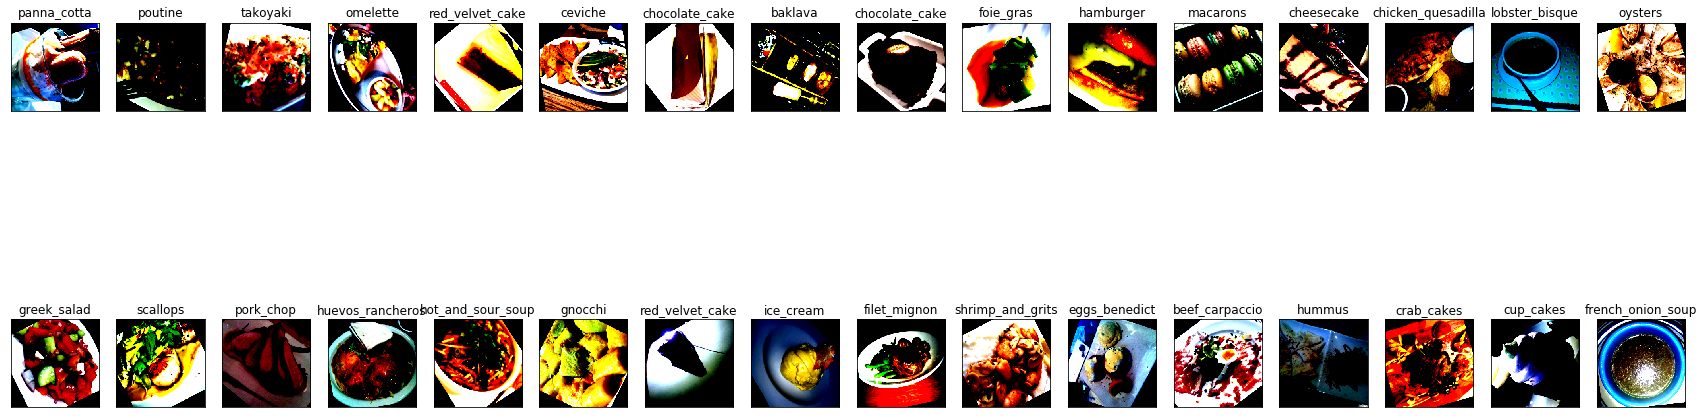

In [0]:
dataiter = iter(train_data_loader)
images, labels = dataiter.next()
images = images.numpy() 

# plot the images and their class 
fig = plt.figure(figsize=(30, 10))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, (batch_size/2), idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

The validation and test images are cropped and resized, but not rotated, flipped, or color augmented.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

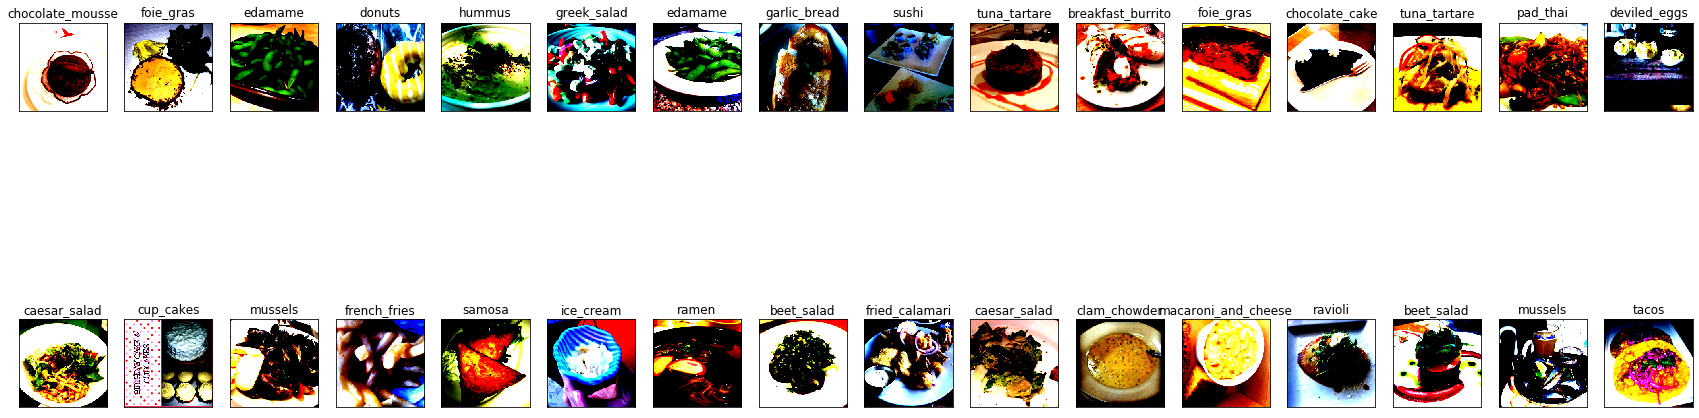

In [0]:
dataiter = iter(valid_data_loader)
images, labels = dataiter.next()
images = images.numpy() 

fig = plt.figure(figsize=(30, 10))
for idx in np.arange(32):
    ax = fig.add_subplot(2, 32/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

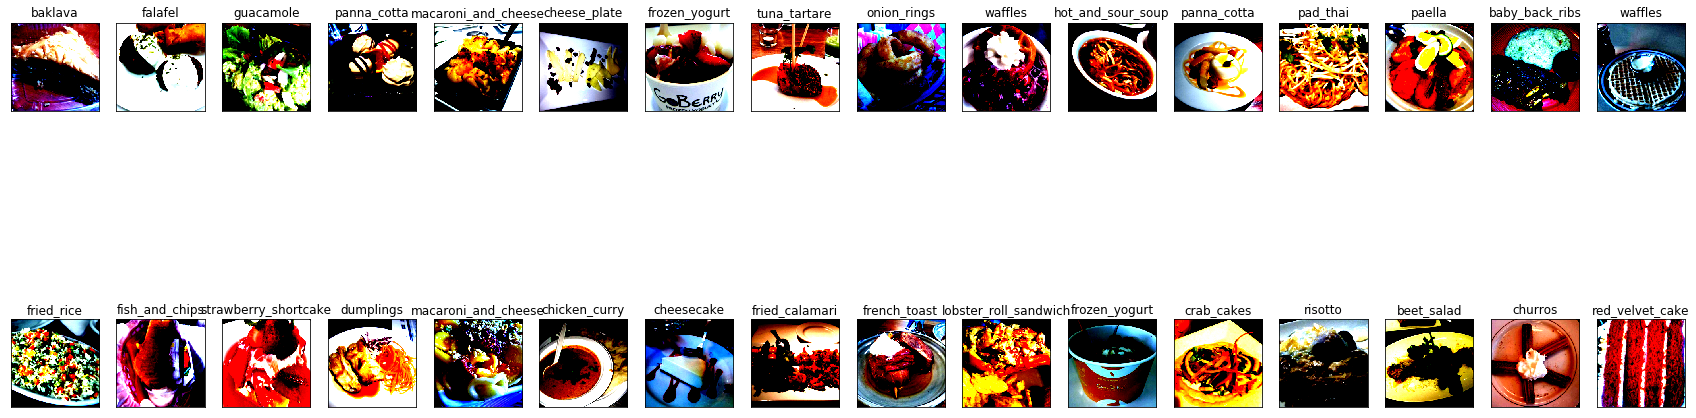

In [0]:
dataiter = iter(test_data_loader)
images, labels = dataiter.next()
images = images.numpy() 

fig = plt.figure(figsize=(30, 10))
for idx in np.arange(32):
    ax = fig.add_subplot(2, 32/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

The following script checks whether GPU is available on your chosen platform.



In [0]:
#use gpu if available

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('Training on CPU.... ')
else:
  print('Training on GPU...')

Training on GPU...


## ResNet50

ResNet is a pre-trained CNN, meaning that it has already identified and extracted features from a dataset.  ResNet50 has 50 layers, and was trained on 1000 image classes. <br>
The architecture of ResNet models is designed with a "skip connection" to reduce the vanishing gradient problem, which occurs when a network has so many layers that gradients from the loss function reduce to zero.  Subsequently, the weights are adjusted and updated.


In [0]:
#download resnet model

model = torchvision.models.resnet50(pretrained=True)

for param in model.parameters():
  param.requires_grad = False

Freezing the final layer and adding a new layer means that the model can train on the specific features in this dataset.  Input layer will depend on the previous layer, hidden layers are customized, and output layer is the number of categories.

In [0]:
input_layer = model.fc.in_features
hidden_layers = [1024, 256]
output_layer = 101

#add a hidden layer, each layer has a ReLU and dropout function except the last
model.fc = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_layer, hidden_layers[0])),
                      ('relu1', nn.ReLU()),
                      ('dropout1', nn.Dropout(p=0.1)),
                      ('fc2', nn.Linear(hidden_layers[0], hidden_layers[1])),
                      ('relu2', nn.ReLU()),
                      ('dropout2', nn.Dropout(p=0.1)),
                      ('fc3', nn.Linear(hidden_layers[1], output_layer)),
                      ('output', nn.LogSoftmax(dim=1))]))


Stochastic Gradient Descent is the optimization method, with a learning rate of 0.01.  0.01 yielded the highest accuracy for the model. <br>
Cross-entropy loss is generally used for classification tasks.  It gives greater loss for wrong predictions, particularly if they are done with higher confidence.

In [0]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01) 
criterion = nn.CrossEntropyLoss()

model.cuda()
print('done')

done


## Training and Validation

In [0]:
#optimal number of epochs before val loss increases

n_epochs = 20

valid_loss_min = np.inf #track change in val loss 

#update classifier and print training and val loss for each epoch

for epoch in range(1, n_epochs + 1):
    
    #keep track of val and training loss
    
    train_loss = 0.0
    valid_loss = 0.0
    
    # train model 
    
    model.train()
    for data, target in train_data_loader:
      if train_on_gpu:
        data, target = data.cuda(), target.cuda()

      #reset gradients      
      optimizer.zero_grad()
      # forward pass
      output = model(data)
      # batch loss
      loss = criterion(output, target)
      #parameter update
      loss.backward()
      optimizer.step()
      #update test loss
      train_loss += loss.item() * data.size(0)
        
    # validate model 

    #set model to evaluation mode    
    model.eval()
    for data, target in valid_data_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
           
    # calculate average loss  
    train_loss = train_loss / len(train_data_loader.dataset)
    valid_loss = valid_loss / len(valid_data_loader.dataset)
    
    # print training/val stats
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
    epoch, train_loss, valid_loss))
    
    #save model if val loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model...'
             .format(valid_loss_min, valid_loss))
        
        torch.save(model.state_dict(), 'resnet50.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 3.519036 	Validation Loss: 0.753025
Validation loss decreased (inf --> 0.753025).  Saving model...
Epoch: 2 	Training Loss: 2.592787 	Validation Loss: 0.537773
Validation loss decreased (0.753025 --> 0.537773).  Saving model...
Epoch: 3 	Training Loss: 2.151309 	Validation Loss: 0.473725
Validation loss decreased (0.537773 --> 0.473725).  Saving model...
Epoch: 4 	Training Loss: 1.974991 	Validation Loss: 0.436123
Validation loss decreased (0.473725 --> 0.436123).  Saving model...
Epoch: 5 	Training Loss: 1.874247 	Validation Loss: 0.420797
Validation loss decreased (0.436123 --> 0.420797).  Saving model...
Epoch: 6 	Training Loss: 1.812225 	Validation Loss: 0.415979
Validation loss decreased (0.420797 --> 0.415979).  Saving model...
Epoch: 7 	Training Loss: 1.767770 	Validation Loss: 0.395936
Validation loss decreased (0.415979 --> 0.395936).  Saving model...
Epoch: 8 	Training Loss: 1.724733 	Validation Loss: 0.389925
Validation loss decreased (0.395936 --> 0

In [0]:
#load model

model.load_state_dict(torch.load('resnet50.pt'))
print(model)

## Testing the Model

The test set has been set aside until training and validation is complete, so the images not yet have been examined in any way.  Using the test set will examine how well the model can generalize to new images.

In [0]:
test_loss = 0.0
class_correct = list(0. for i in range(101))
class_total = list(0. for i in range(101))

model.eval() # eval mode

# iterate over test data
for data, target in test_data_loader:
    # move tensors to GPU
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()

    output = model(data)
    loss = criterion(output, target) 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
      label = target.data[0]
      class_correct[label] += correct[0].item()
      class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_data_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(101):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.468561

Test Accuracy of apple_pie: 14% (32/224)
Test Accuracy of baby_back_ribs: 88% (256/288)
Test Accuracy of baklava: 16% (32/192)
Test Accuracy of beef_carpaccio: 50% (128/256)
Test Accuracy of beef_tartare: 50% (96/192)
Test Accuracy of beet_salad: 50% (96/192)
Test Accuracy of beignets: 50% (128/256)
Test Accuracy of bibimbap: 100% (64/64)
Test Accuracy of bread_pudding: 25% (32/128)
Test Accuracy of breakfast_burrito: 57% (128/224)
Test Accuracy of bruschetta: 45% (160/352)
Test Accuracy of caesar_salad: 44% (128/288)
Test Accuracy of cannoli: 75% (192/256)
Test Accuracy of caprese_salad: 16% (32/192)
Test Accuracy of carrot_cake: 71% (160/224)
Test Accuracy of ceviche: 18% (64/352)
Test Accuracy of cheese_plate:  0% ( 0/288)
Test Accuracy of cheesecake: 33% (96/288)
Test Accuracy of chicken_curry: 14% (32/224)
Test Accuracy of chicken_quesadilla: 75% (288/384)
Test Accuracy of chicken_wings: 81% (288/352)
Test Accuracy of chocolate_cake: 60% (96/160)
Test Accuracy


Examine a batch of images and their predicted class vs actual class.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

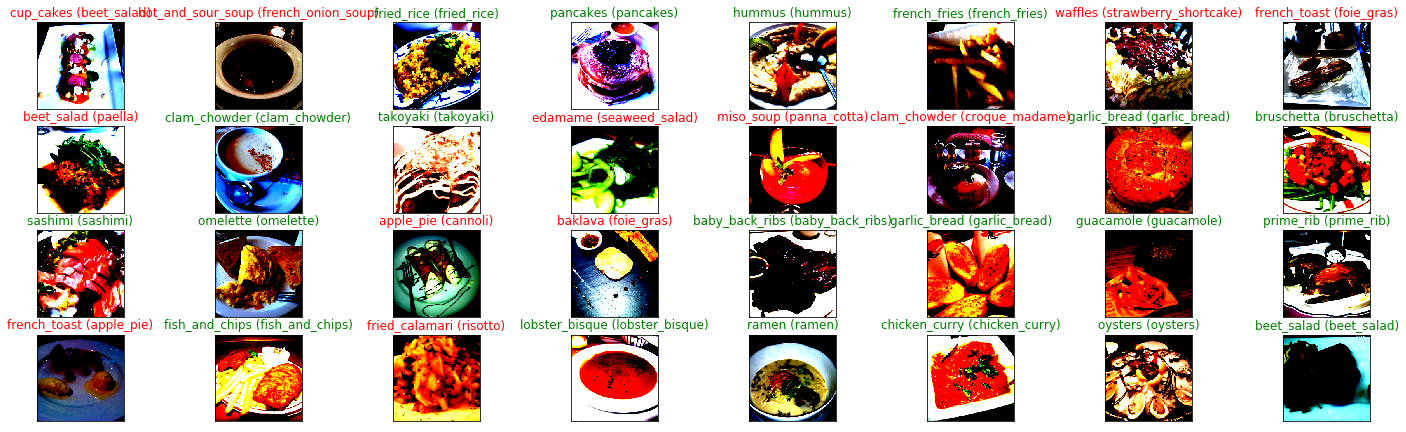

In [0]:
dataiter = iter(test_data_loader)
images, labels = dataiter.next()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
images = images.cpu()
preds =  np.squeeze(preds_tensor.cpu().numpy())


# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 15))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(8, batch_size/4, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

## Top Results

The classes with the highest accuracy are (all at 100%):
 - bibimbap
 - donuts
 - edamame
 - ice cream
 - macarons
 - pancakes 

The lowest accuray (under 15%):
 - cheese plate (0)%
 - ravioli (0%)
 - grilled salmon (0%)
 - chocolate mousse (11%)
 - apple pie (14%)
 - tiramisu (14%)
 - chicken curry (14%)



## WIP
**work in progress**
Let's take some of the lowest accuracy classes and see what they are being predicted as.

In [0]:
def process_image(image):

  transform = test_transform

  load_data = Image.open(image)
  load_data = transform(load_data).float()
  np_image = np.array(load_data)
    
  return np_image

image = test_folder + '/chocolate_mousse/' + '1379570.jpg'
img = process_image(image)
print('Image shape:', img.shape)

Image shape: (3, 224, 224)


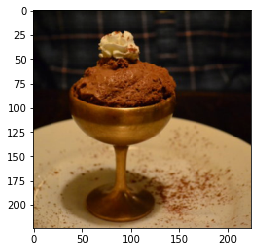

In [0]:
def show_image(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
      
    image = image.transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

image = test_folder + '/chocolate_mousse/' + '1379570.jpg'
show_image(process_image(image))

In [0]:


def predict(image_path, model, topk=5):

    model.eval()
    model.to('cuda')
    
    img_torch = process_image(image_path)
    img_torch = torch.from_numpy(img_torch)
    
    img_torch = img_torch.unsqueeze_(0)
    img_torch = img_torch.float()
    
    with torch.no_grad():
        output = model.forward(img_torch.cuda()) 
        
    transform = F.softmax(output.data,dim=1) 

    return transform.topk(topk)

probs, class_tensor = predict(image, model)
print(probs)
print(class_tensor)

tensor([[0.8220, 0.1013, 0.0311, 0.0114, 0.0067]], device='cuda:0')
tensor([[58, 22, 98, 21,  8]], device='cuda:0')


In [0]:
def check_topk(path):

  index = (path.split('/')[2])
  image = process_image(path)

  plot = imshow(image, ax = plt)
  plot.axis('off')
  plot.title(class_to_idx[str(index)])
  plot.show()

  axes = predict(image, model)

  yaxis = [class_to_idx[str(i)] for i in np.array(axes[1][0].cpu())]
  y_pos = np.arange(len(yaxis))
  xaxis = np.array(axes[0][0].cpu().numpy())   

  plt.barh(y_pos, xaxis)
  plt.xlabel('probability')
  plt.yticks(y_pos, yaxis)

  plt.show()

In [0]:
path =  test_folder + '/chocolate_mousse/' + '1379570.jpg'
check_topk(path)

## Summary and Takeaway
Overall, the model performed highest on foods that had a distinct color and texture pattern.  General shape may still play an important role in how the model determines its class.  Pancakes, edamame, and macarons, for example, are generally the same shape and color.  Chocolate mousse, apple pie, cheese plates, and chicken curry probably have differing shapes and a lack of consistent detail patterns. <br>
In the future, I would be interested in the following:

*   Visually investigate how a CNN is organizing patterns through feature maps[1] [2].  This could give an idea of how classifications are being determined.
*   Use heatmaps to see what areas are being activated during classifications.  This will show what sort of patterns the CNN is identifying as important for each class[3] [4].
*   Using mixup data augmentation is a new and interesting technique that I think deserves some attention in the future[5] [6] [7].
<br><br>
I would also like to implement the following features to reduce time spent on tuning the model:
<br><br>
*   Early stopping method, which will stop training the model when validation loss begins to increase, thus reducing the chance of overfitting.
*   A learning rate finder, which will detemrine the optimal LR before proceeding to training.  This means less training, tuning, and re-training.
*   Some of the transformed images are darker than I would like.  I would like to explore better methods of color augmentation, where I can adjust brightness and saturation without getting dark images as well.

[[1]](https://arxiv.org/pdf/1507.02313.pdf) Athiwaratkun, B., & Kang, K. (2015). Feature representation in convolutional neural networks. arXiv preprint arXiv:1507.02313. <br>
[[2]](https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/) Brownlee, J. (2019) How to Visualize Filters and Feature Maps in Convolutional Neural Networks. Medium Article <br>
[[3]](http://openaccess.thecvf.com/content_ICCV_2017/papers/Selvaraju_Grad-CAM_Visual_Explanations_ICCV_2017_paper.pdf) Selvaraju, R. R., Cogswell, M., Das, A., Vedantam, R., Parikh, D., & Batra, D. (2017). Grad-cam: Visual explanations from deep networks via gradient-based localization. In Proceedings of the IEEE international conference on computer vision (pp. 618-626). <br>
[[4]](https://heartbeat.fritz.ai/heatmaps-and-convolutional-neural-networks-using-fast-ai-16d5b7d02a86) Vasani, D. (2019) Heatmaps and CNNs Using Fast.ai. Heartbeat.Fritz.ai <br>
[[5]](https://www.inference.vc/mixup-data-dependent-data-augmentation) inFERENCe (2017) mixup: Data-Dependent Data Augmentation <br>
[[6]](https://github.com/fastai/fastai2/blob/master/nbs/19_callback.mixup.ipynb)GitHub code for mixup <br>
[[7]](https://arxiv.org/abs/1710.09412) H Zhang, M Cisse, YN Dauphin and D Lopez-Paz (2017) mixup: Beyond Empirical Risk Minimization
